In [22]:
import importlib
import os
import sys
import warnings
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as md
import plotly.graph_objects as go

from mplfinance.original_flavor import candlestick_ohlc

from dotenv import load_dotenv

warnings.filterwarnings("ignore")

In [23]:
# Makes sure modules are available to the notebook that acts as an entrypoint

load_dotenv()

parent_dir = os.path.abspath('..')

if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [24]:
# Manually reloading python module such that jupyter reflects changes without kernel restart

import plutus.code.calc.sr as sr

importlib.reload(sr);

In [25]:
import plutus.code.api_connector as ac

importlib.reload(ac);

In [26]:
# data_source = 'uds'

# ticker = 'CRM'
# start_date = "2022-10-04-00:00"
# end_date = "2022-10-05-00:00"
# n_periods = 1

# api_connector = ac.ApiConnector(data_source)
# api_connector.ticker = ticker
# api_connector.start_date = start_date
# api_connector.end_date = end_date
# api_connector.n_periods = n_periods

# df = api_connector.request_daily_prices()[0]

input_file = 'rolling_window_debug.csv'

df = pd.read_csv(os.getcwd() + f'/../outputs/{input_file}')



"""
Turn date indices into datetime objects and then parse to matplotlib dates
Needed for candles rendering
"""

date_column = 'datetime'

df[date_column] = pd.to_datetime(df[date_column])

df[date_column] = df[date_column].apply(md.date2num)

# Select columns we are interested in
df = df[[date_column, 'open', 'high', 'low', 'close']]

In [27]:
"""
Identify support and resistance levels and persist them on the dataframe
"""

sr_calculator = sr.SupportAndResistanceCalculator()

sr_calculator.dataframe = df

sr_calculator.calculate_sr_levels()

df

[190.089  190.115  190.115  190.09   190.095  190.1899 190.2052 190.1899
 190.189  190.2027 190.19   190.1    190.2163 190.22   190.2314 190.215
 190.19   190.16   190.17   190.17   190.11   190.1525 190.115  190.11
 190.0799 190.1153 190.07   190.11   190.135  190.09   190.085  190.07
 190.11   190.125  190.12   190.125  190.14   190.19   190.18   190.15
 190.11   190.0801 190.155  190.215  190.2    190.21   190.205  190.205 ]
7.606028
[182.482972 182.508972 182.508972 182.483972 182.488972 182.583872
 182.599172 182.583872 182.582972 182.596672 182.583972 182.493972
 182.610272 182.613972 182.625372 182.608972 182.583972 182.553972
 182.563972 182.563972 182.503972 182.546472 182.508972 182.503972
 182.473872 182.509272 182.463972 182.503972 182.528972 182.483972
 182.478972 182.463972 182.503972 182.518972 182.513972 182.518972
 182.533972 182.583972 182.573972 182.543972 182.503972 182.474072
 182.548972 182.608972 182.593972 182.603972 182.598972 182.598972]
[190.42   190.43   190

datetime      open     high       low     close  sr_level_1  \
0    19552.729861  190.0500  190.100  190.0150  190.0890    190.1507   
1    19552.730556  190.0800  190.095  189.9600  189.9837    190.1507   
2    19552.731250  189.9900  190.045  189.9501  190.0349    190.1507   
3    19552.731944  190.0361  190.120  190.0301  190.1150    190.1507   
4    19552.732639  190.1200  190.150  190.0901  190.1150    190.1507   
..            ...       ...      ...       ...       ...         ...   
385  19552.997222  190.7250  190.730  190.7000  190.7150    190.1507   
386  19552.997917  190.7012  190.730  190.7000  190.7000    190.1507   
387  19552.998611  190.7000  190.730  190.6900  190.7289    190.1507   
388  19552.999306  190.7000  190.730  190.7000  190.7200    190.1507   
389  19555.824306  191.2900  194.335  190.9200  190.6900    190.1507   

     sr_level_2  
0       190.615  
1       190.615  
2       190.615  
3       190.615  
4       190.615  
..          ...  
385     190.615  
386     190.615  
387     190.615  
388     190.615  
389     190.615  

[390 rows x 7 columns]

In [28]:
pd.options.plotting.backend = 'plotly'

colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo']

fig = df.plot.scatter(
    x=df['close'].index,
    y="close",
    color=[colors[i] for i in sr_calculator.clusters],
)

# Configure some styles
layout = go.Layout(
    plot_bgcolor='#efefef',
    showlegend=False,
    font_family='Monospace',
    font_color='#000000',
    font_size=20,
    xaxis=dict(
        rangeslider=dict(
            visible=False
        ))
)

fig.update_layout(layout)

# Display plot in local browser window
fig.show()


ValueError: All arguments should have the same length. The length of argument `color` is 0, whereas the length of  previously-processed arguments ['index', 'close'] is 390

In [ ]:
fig = df['close'].plot.scatter(
    x=df['close'].index,
    y="close",
    color=[colors[i] for i in sr_calculator.clusters],
)

# Average within clusters
for cluster_avg in sr_calculator.cluster_avgs:

    fig.add_hline(y=cluster_avg[1], line_width=1, line_color="blue")

fig.update_layout(layout)

fig.show()

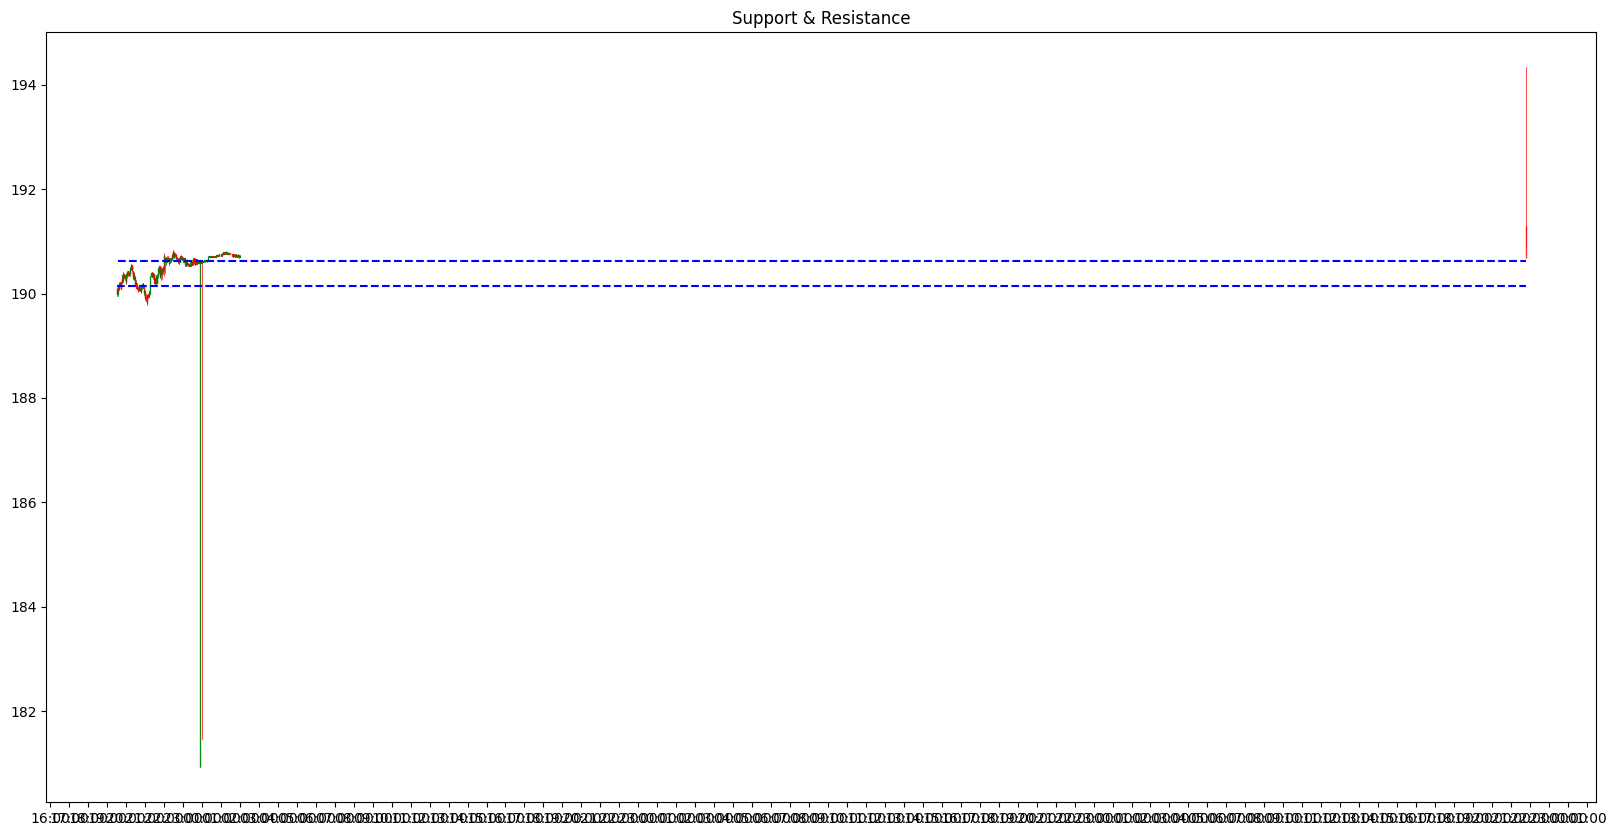

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))

plt.title(f'Support & Resistance')

majorFmt = md.DateFormatter('%H:%M', 'CET')
ax.xaxis.set_major_formatter(majorFmt)

xloc=md.HourLocator(interval=1)
ax.xaxis.set_major_locator(xloc)

width = .00035

candlestick_ohlc(ax, df.values, width=width, colorup='green', colordown='red', alpha=0.8)

for cluster_avg in sr_calculator.cluster_avgs:

    plt.hlines(
      cluster_avg[1], xmin = df[date_column][cluster_avg[0]], xmax = max(df[date_column]), colors='blue', linestyle='--'
    )